# Impact on Industry and Commerce

* Percentage of commercial and commericial buildings damaged
* Percentage of commercial and industrial buildings without electricity 
* Percentage of places of economic activity damaged

In [1]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from palettable.cartocolors.qualitative import Prism_10, Vivid_10
from palettable.tableau import ColorBlind_10, TableauMedium_10

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Overall Impact on Industry and Commerce

In [197]:
sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
summary_stats.reset_index(inplace=True)
summary_stats['ADM2_EN'] = pd.Categorical(summary_stats['ADM2_EN'], categories=sort_order, ordered=True)
summary_stats.sort_values(by='ADM2_EN', inplace=True)
summary_stats.rename(columns = {'ADM2_EN':'Governorate'}, inplace=True)
summary_stats.set_index('Governorate', inplace=True)

In [183]:
summary_stats[['% Commercial Buildings Damaged','% Industrial Buildings Damaged', '% Critical Infrastructure Damaged','% Places of Economic Activity Damaged', '% Industrial Buildings without Observed Nighttime Lights', '% Commercial Buildings without Observed Nighttime Lights', '% Primary and Secondary Roads Damaged']].style.background_gradient(cmap='viridis', axis=0).format("{:.0f}%")

,% Commercial Buildings Damaged,% Industrial Buildings Damaged,% Critical Infrastructure Damaged,% Places of Economic Activity Damaged,% Industrial Buildings without Observed Nighttime Lights,% Commercial Buildings without Observed Nighttime Lights,% Primary and Secondary Roads Damaged
Governorate,,,,,,,
North Gaza,50%,63%,49%,66%,29%,67%,63%
Gaza,86%,59%,71%,76%,49%,96%,63%
Deir Al-Balah,33%,40%,56%,34%,83%,100%,20%
Khan Younis,50%,34%,46%,44%,49%,100%,29%
Rafah,30%,44%,55%,49%,nan%,nan%,33%


## Observations

* The Governorate of Gaza has seen the highest impact for industry and commerce.
* North Gaza has the second highest amount of roads damaged both in absolute figures and percentage values.
* While some of the industrial buildings are damaged, a higher percentage of them do not have oberserved nighttime lights. This could slow down economic activity significantly

In [202]:
summary_stats[['Number of Commercial Buildings Damaged','Number of Industrial Buildings Damaged', 'Number of Points of Critical Infrastructure Damaged','Number of Places of Economic Activity Damaged', 'Primary and Secondary Damaged Roads (in km)']].style.background_gradient(cmap='viridis', axis=0).format("{:.0f}")

,Number of Commercial Buildings Damaged,Number of Industrial Buildings Damaged,Number of Points of Critical Infrastructure Damaged,Number of Places of Economic Activity Damaged,Primary and Secondary Damaged Roads (in km)
Governorate,,,,,
North Gaza,1,152,25,318,3527
Gaza,18,277,35,957,12733
Deir Al-Balah,1,78,14,191,374
Khan Younis,3,40,18,195,2062
Rafah,3,26,12,74,2190


In [2]:
# read shapefiles
PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm1_pamop_20231019.shp"
)
PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm2_pamop_20231019.shp"
)
GAZA = PSE[PSE["ADM1_EN"] == "Gaza Strip"]

In [208]:
BUILDINGS_OSM = geopandas.read_file(
    "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_OSM_buildings_02Feb2024_2_5sigma.shp"
).to_crs("EPSG:4326")

BUILDINGS_OSM = geopandas.sjoin(BUILDINGS_OSM, GAZA)
BUILDINGS_OSM["type"] = BUILDINGS_OSM["type"].fillna("")

In [209]:
commerce = BUILDINGS_OSM[BUILDINGS_OSM['type'].isin(['commericial', 'warehouse', 'retail', 'service', 'hotel', 'yes;commercial', 'garage'])]
industry = BUILDINGS_OSM[BUILDINGS_OSM['type'].isin(['industry', 'construction', 'industrial'])]

commerce.loc[:,'type'] = 'commercial'
industry.loc[:,'type'] = 'industry'

In [210]:
def get_percentage(industry_and_commerce):
    left = (
        industry_and_commerce[industry_and_commerce["_up7mean"] >= 0.2]
        .value_counts(["ADM2_EN", "type"])
        .to_frame("damaged")
    )
    right = industry_and_commerce.value_counts(["ADM2_EN", "type"]).to_frame("total")

    df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
    df["perc"] = 100 * df["damaged"] / df["total"]

    sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
    df['ADM2_EN'] = pd.Categorical(df['ADM2_EN'], categories=sort_order, ordered=True)
    df.sort_values(by='ADM2_EN', inplace=True)

    return df

In [211]:
industry = get_percentage(industry)
commerce = get_percentage(commerce)

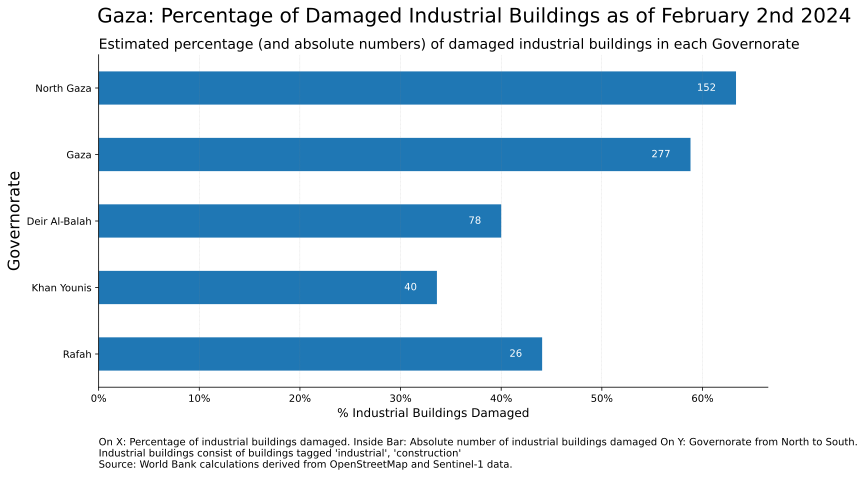

In [215]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.suptitle(
    "Gaza: Percentage of Damaged Industrial Buildings as of February 2nd 2024",
    y=0.99,
    fontsize=20,
    x=0.56,
)

absolute_damage_numbers = list(industry.pivot_table("damaged", "ADM2_EN", "type", observed=False).sort_values(by='ADM2_EN', ascending = False)["industry"])

ax = industry[industry['type']=='industry'].pivot_table("perc", "ADM2_EN", "type", observed = False).sort_values(by='ADM2_EN', ascending = False)["industry"].plot(
    ax=ax, kind="barh", legend = False)

# Add labels and customization
ax.set_xlabel("% Industrial Buildings Damaged", fontsize=12)

ax.set_ylabel("Governorate", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))

ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
#ax.legend()

ax.set_title(
    "Estimated percentage (and absolute numbers) of damaged industrial buildings in each Governorate",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.2,
    "On X: Percentage of industrial buildings damaged. Inside Bar: Absolute number of industrial buildings damaged On Y: Governorate from North to South.\nIndustrial buildings consist of buildings tagged 'industrial', 'construction'\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

for id, bar in enumerate(ax.patches):
    width = bar.get_width()  # Use width since the bars are horizontal
    ax.annotate(f'{int(np.round(absolute_damage_numbers[id],0))}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",color = 'white',
                ha='right', va='center');

### Observations and Limitations

* The number of buildings tagged as industrial and commerical on the OpenStreetMap database are few, this could explain the high percentge of damage seen in the North Gaza Governorate. 

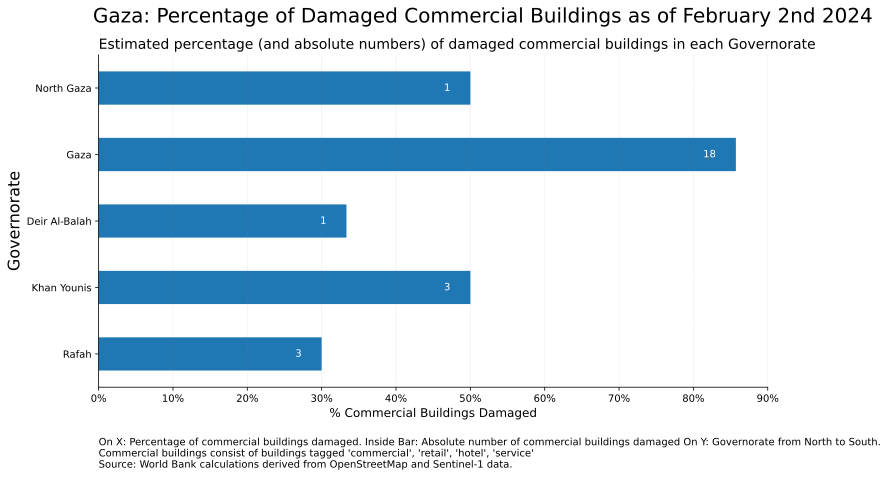

In [218]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.suptitle(
    "Gaza: Percentage of Damaged Commercial Buildings as of February 2nd 2024",
    y=0.99,
    fontsize=20,
    x=0.57,
)

absolute_damage_numbers = list(commerce.pivot_table("damaged", "ADM2_EN", "type", observed=False).sort_values(by='ADM2_EN', ascending = False)["commercial"])

ax = commerce.pivot_table("perc", "ADM2_EN", "type", observed = False).sort_values(by='ADM2_EN', ascending = False)["commercial"].plot(
    ax=ax, kind="barh", legend = False)

# Add labels and customization
ax.set_xlabel("% Commercial Buildings Damaged", fontsize=12)

ax.set_ylabel("Governorate", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))

ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
#ax.legend()

ax.set_title(
    "Estimated percentage (and absolute numbers) of damaged commercial buildings in each Governorate",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.2,
    "On X: Percentage of commercial buildings damaged. Inside Bar: Absolute number of commercial buildings damaged On Y: Governorate from North to South.\nCommercial buildings consist of buildings tagged 'commercial', 'retail', 'hotel', 'service'\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

for id, bar in enumerate(ax.patches):
    width = bar.get_width()  # Use width since the bars are horizontal
    ax.annotate(f'{int(np.round(absolute_damage_numbers[id],0))}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",color = 'white',
                ha='right', va='center');

## Percentage of Points of Interest Damaged

In [73]:
POI = geopandas.read_file(
    "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_pois_1_02Feb2024_2_5sigma.shp"
).to_crs("EPSG:4326")

POI = geopandas.sjoin(POI, GAZA)
POI["fclass"] = POI["fclass"].fillna("")

In [74]:
def get_poi_classification(fclass):
    if fclass in [
        "school",
        "kindergarten",
        "university",
        "college",
    ]:
        return "Education"
    if fclass in [
        "tower",
        "wastewater_plant",
        "water_tower",
        "telephone",
        "water_well",
        "drinking_water",
        "recycling",
    ]:
        return "Critical Infrastructure"
    if fclass in [
        "pharmacy",
        "dentist",
        "doctors",
        "hospital",
        "clinic",
        "nursing_home",
    ]:
        return "Health"
    if fclass in [
        "public_building",
        "police",
        "courthouse",
        "library",
        "monument",
        "post_office",
        "memorial",
        "community_centre",
        "town_hall",
        "museum",
        "arts_centre",
        "sports_centre",
        "tourist_info",
        "fire_station",
    ]:
        return "Public Amenities"

    elif fclass in [
        "clothes",
        "supermarket",
        "restaurant",
        "laundry",
        "cafe",
        "computer_shop",
        "convenience",
        "furniture_shop",
        "shoe_shop",
        "bakery",
        "hotel",
        "hairdresser",
        "fast_food",
        "bank",
        "viewpoint",
        "artwork",
        "picnic_site",
        "chalet",
        "caravan_site",
        "greengrocer",
        "beauty_shop",
        "car_dealership",
        "attraction",
        "pub",
        "waste_basket",
        "nightclub",
        "playground",
        "department_store",
        "outdoor_shop",
        "atm",
        "butcher",
        "car_rental",
        "doityourself",
        "guesthouse",
        "beverages",
        "theatre",
        "newsagent",
        "cinema",
        "mobile_phone_shop",
        "car_wash",
        "bookshop",
        "hostel",
        "sports_shop",
        "castle",
        "pitch",
        "car_sharing",
        "vending_machine",
        "food_court",
        "gift_shop",
        "camp_site",
        "veterinary",
        "post_box",
        "florist",
        "jeweller",
        "chemist",
        "motel",
        "alpine_hut",
        "mall",
        "kiosk",
        "bicycle_shop",
        "bench",
        "optician",
        "travel_agent",
        "biergarten",
        "toy_shop",
        "bar",
        "fountain",
        "archaeological",
        "shelter",
        "park",
        "stationery",
        "market_place",
        "zoo",
    ]:
        return "Places of Economic Activity"

In [75]:
POI["type"] = POI["fclass"].apply(get_poi_classification)

In [219]:
left = POI[POI["_up7max"] >= 0.5].value_counts(["ADM2_EN", "type"]).to_frame("damaged")
right = POI.value_counts(["ADM2_EN", "type"]).to_frame("total")

df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
df["perc"] = 100 * df["damaged"] / df["total"]

In [220]:
sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
df['ADM2_EN'] = pd.Categorical(df['ADM2_EN'], categories=sort_order, ordered=True)
df.sort_values(by='ADM2_EN', inplace=True)

In [221]:
economy = df[df['type']=='Places of Economic Activity']
# education = education.pivot_table("perc", "ADM2_EN", "type", observed=False)[['Education']].sort_values(by='ADM2_EN', ascending = False)
economy = economy[['ADM2_EN', 'damaged', 'total', 'perc']]


critical_infrastructure = df[df['type']=='Critical Infrastructure']
# education = education.pivot_table("perc", "ADM2_EN", "type", observed=False)[['Education']].sort_values(by='ADM2_EN', ascending = False)
critical_infrastructure = critical_infrastructure[['ADM2_EN', 'damaged', 'total', 'perc']]

In [222]:
sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
economy['ADM2_EN'] = pd.Categorical(economy['ADM2_EN'], categories=sort_order, ordered=True)
economy.sort_values(by='ADM2_EN', inplace=True)

sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
critical_infrastructure['ADM2_EN'] = pd.Categorical(critical_infrastructure['ADM2_EN'], categories=sort_order, ordered=True)
critical_infrastructure.sort_values(by='ADM2_EN', inplace=True)

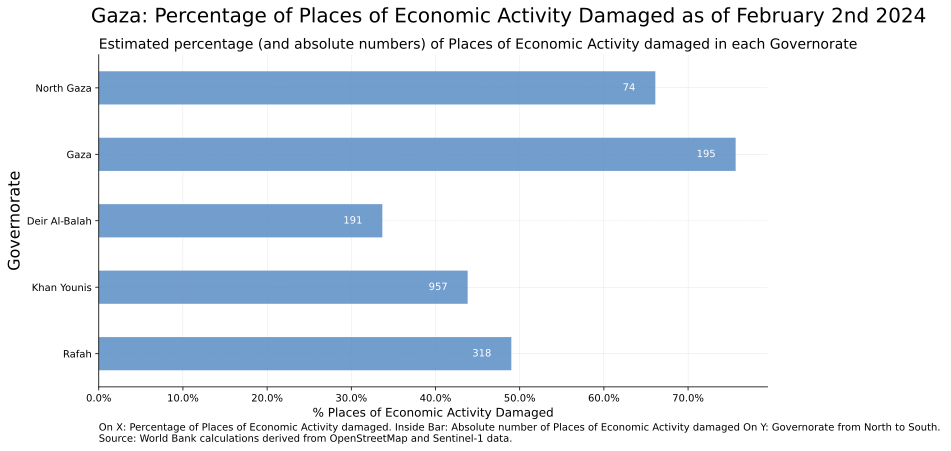

In [223]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
plt.suptitle("Gaza: Percentage of Places of Economic Activity Damaged as of February 2nd 2024", y=0.99, fontsize=20, x=0.6)

absolute_damage_numbers = list(economy.pivot_table("damaged", "ADM2_EN", observed=False)["damaged"])


ax = economy.pivot_table("perc", "ADM2_EN", observed=False)[['perc']].sort_values(by='ADM2_EN', ascending = False).plot(
    ax=ax, kind="barh", color=TableauMedium_10.mpl_colors, legend = False
)

# Add labels and customization
ax.set_xlabel("% Places of Economic Activity Damaged", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))
ax.set_ylabel("Governorate", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
# ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated percentage (and absolute numbers) of Places of Economic Activity damaged in each Governorate",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.14,
    "On X: Percentage of Places of Economic Activity damaged. Inside Bar: Absolute number of Places of Economic Activity damaged On Y: Governorate from North to South. \nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

for id, bar in enumerate(ax.patches):
    width = bar.get_width()  # Use width since the bars are horizontal
    ax.annotate(f'{int(np.round(absolute_damage_numbers[id],0))}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",color = 'white',
                ha='right', va='center');

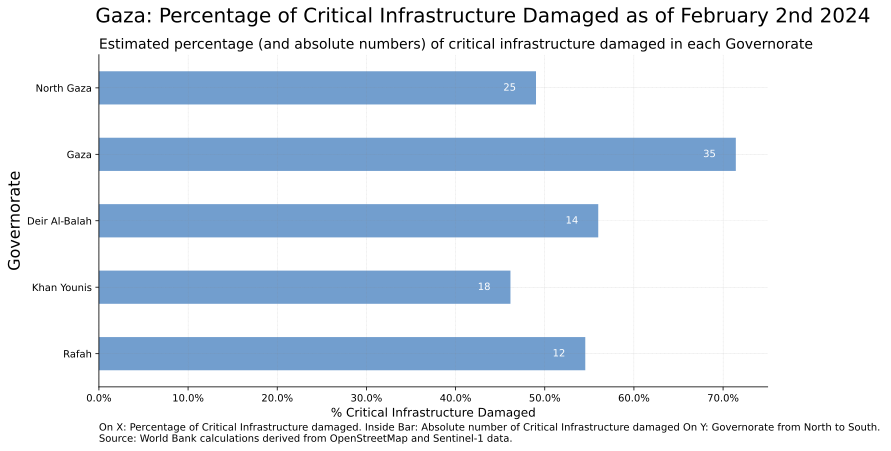

In [225]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
plt.suptitle("Gaza: Percentage of Critical Infrastructure Damaged as of February 2nd 2024", y=0.99, fontsize=20, x=0.57)

absolute_damage_numbers = list(critical_infrastructure.pivot_table("damaged", "ADM2_EN", observed=False).sort_values(by='ADM2_EN', ascending = False)["damaged"])


ax = critical_infrastructure.pivot_table("perc", "ADM2_EN", observed=False)[['perc']].sort_values(by='ADM2_EN', ascending = False).plot(
    ax=ax, kind="barh", color=TableauMedium_10.mpl_colors, legend = False
)

# Add labels and customization
ax.set_xlabel("% Critical Infrastructure Damaged", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))
ax.set_ylabel("Governorate", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
# ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated percentage (and absolute numbers) of critical infrastructure damaged in each Governorate",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.14,
    "On X: Percentage of Critical Infrastructure damaged. Inside Bar: Absolute number of Critical Infrastructure damaged On Y: Governorate from North to South. \nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

for id, bar in enumerate(ax.patches):
    width = bar.get_width()  # Use width since the bars are horizontal
    ax.annotate(f'{int(np.round(absolute_damage_numbers[id],0))}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",color = 'white',
                ha='right', va='center');

## Percentage of Industrial and Commerical Buildings without Observed Nighttime Lights

Lower nighttime lights intensity indicative of darker areas may correspond to higher numbers of residential buildings without electricity. The chart below shows the percentage of residential buildings retrieved from [OpenStreetMap](https://www.hotosm.org) for which the nighttime lights intensity has decreased as of December 2023 by at least 95% compared to September 2023 for each governorate in Gaza.

In [234]:
ntl = pd.read_csv("../../data/ntl/PSE_2-buildings_without_electricity.csv", index_col="name")[['% industrial buildings without electricity', '% commercial buildings without electricity']]
ntl.rename(columns = {'% industrial buildings without electricity':'industrial', '% commercial buildings without electricity':'commercial'}, inplace=True)

ntl = ntl.reset_index()
ntl.rename(columns = {'name':'ADM2_EN'}, inplace=True)
ntl.set_index('ADM2_EN', inplace=True)

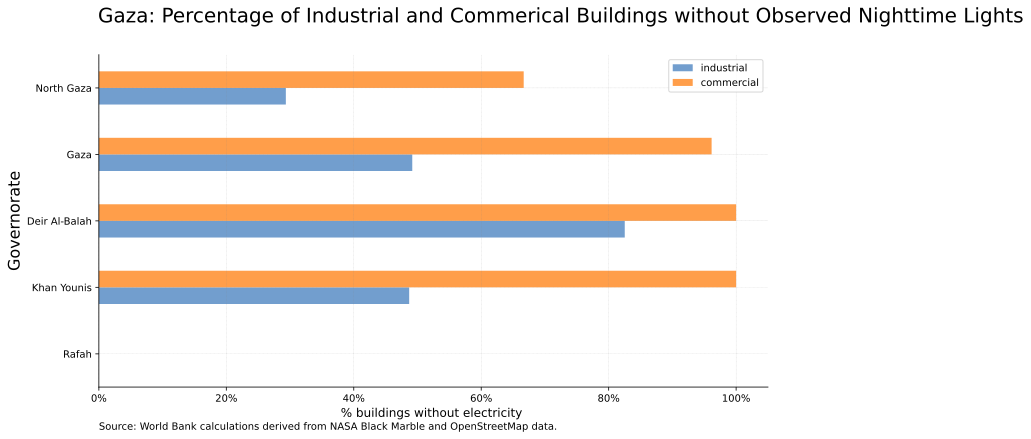

In [235]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.suptitle(
    "Gaza: Percentage of Industrial and Commerical Buildings without Observed Nighttime Lights", y=0.99, fontsize=20, x=0.66
)

data = ntl[['industrial', 'commercial']].plot(ax=ax, kind="barh", color=TableauMedium_10.mpl_colors)

# Add labels and customization
ax.set_xlabel("% buildings without electricity ", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))
ax.set_ylabel("Governorate", fontsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)

# ax.set_title(
#     "Estimated percentage of buildings without electricity for each governorate",
#     fontsize=14,
# )
ax.text(
    0,
    -0.12,
    "Source: World Bank calculations derived from NASA Black Marble and OpenStreetMap data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

```{warning}
It's important to be aware of the limitations and potential inaccuracies associated with using OpenStreetMap (OSM) data for analysis. While OSM provides a valuable source of geographic information, it may not always be comprehensive or up-to-date. Additionally, the granularity of OSM data can vary, leading to coarse sample sizes in certain regions. Failure to account for these limitations could result in misleading conclusions or ineffective strategies.
```

## Percentage of Roads Damaged

In [120]:
ROADS = geopandas.read_file(
    "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_roads_lines_02Feb2024_2_5sigma.shp"
).to_crs("EPSG:4326")

ROADS = geopandas.sjoin(ROADS, GAZA)

In [122]:
mapper = {
    "track": "Tracks",
    "unclassified": "Unclassified",
    "residential": "Other",
    "tertiary": "Tertiary",
    "service": "Other",
    "secondary": "Secondary",
    "track_grade3": "Tracks",
    "track_grade5": "Tracks",
    "trunk": "Other",
    "path": "Other",
    "track_grade4": "Tracks",
    "primary": "Primary",
    "secondary_link": "Secondary",
    "footway": "Other",
    "steps": "Other",
    "tertiary_link": "Tertiary",
    "trunk_link": "Other",
    "pedestrian": "Other",
    "primary_link": "Primary",
    "living_street": "Other",
    "unknown": "Unclassified",
    "track_grade1": "Tracks",
}
ROADS["type"] = ROADS["fclass"].replace(mapper)

In [226]:
def get_percentage(ROADS):
    left = (
        ROADS[ROADS["_up7max"] >= 0.5]
        .value_counts(["ADM2_EN", "type"])
        .to_frame("damaged")
    )
    right = ROADS.value_counts(["ADM2_EN", "type"]).to_frame("total")

    df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
    df["perc"] = 100 * df["damaged"] / df["total"]

    sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
    df['ADM2_EN'] = pd.Categorical(df['ADM2_EN'], categories=sort_order, ordered=True)
    df.sort_values(by='ADM2_EN', inplace=True, ascending = True)

    return df

In [227]:
primary_secondary_roads = ROADS[ROADS['type'].isin(['Primary', 'Secondary'])]
primary_secondary_roads.loc[:,'type'] = 'Primary and Secondary'

primary_secondary_roads = get_percentage(primary_secondary_roads)

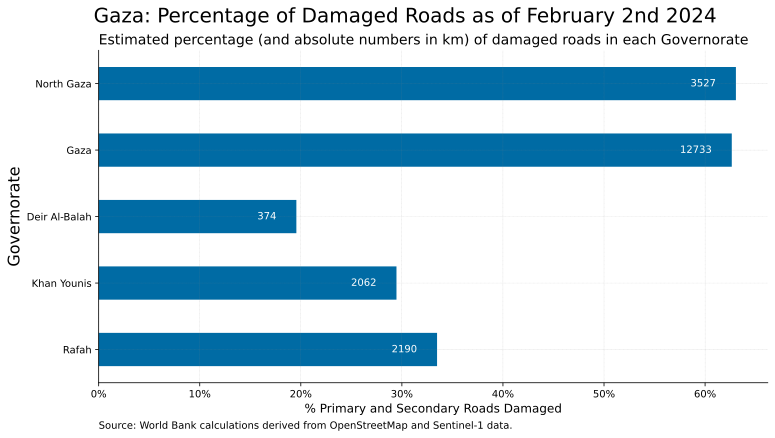

In [231]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.suptitle("Gaza: Percentage of Damaged Roads as of February 2nd 2024", y=0.98, fontsize=20, x=0.48)

absolute_damage_numbers = list(primary_secondary_roads.pivot_table("damaged", "ADM2_EN", observed=False).sort_values(by='ADM2_EN', ascending = False)["damaged"])


ax = primary_secondary_roads.pivot_table("perc", "ADM2_EN", "type", observed=False).sort_values(by='ADM2_EN', ascending = False).plot(
    ax=ax, kind="barh", color=ColorBlind_10.mpl_colors, legend = False
)

# Add labels and customization
ax.set_xlabel("% Primary and Secondary Roads Damaged", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))
ax.set_ylabel("Governorate", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
#ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated percentage (and absolute numbers in km) of damaged roads in each Governorate",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.13,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

for id, bar in enumerate(ax.patches):
    width = bar.get_width()  # Use width since the bars are horizontal
    ax.annotate(f'{int(np.round(absolute_damage_numbers[id],0))}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",color = 'white',
                ha='right', va='center');

In [172]:
ntl = pd.read_csv("../../data/ntl/PSE_2-buildings_without_electricity.csv", index_col="name")[['% industrial buildings without electricity', '% commercial buildings without electricity']]
ntl.rename(columns = {'% industrial buildings without electricity':'% Industrial Buildings without Observed Nighttime Lights', '% commercial buildings without electricity':'% Commercial Buildings without Observed Nighttime Lights'}, inplace=True)

ntl = ntl.reset_index()
ntl.rename(columns = {'name':'ADM2_EN'}, inplace=True)

In [189]:
critical_infrastructure.rename(columns = {'perc':'% Critical Infrastructure Damaged','damaged':'Number of Points of Critical Infrastructure Damaged'}, inplace=True)
#economy.rename(columns = {'damaged':'Number of Places of Economic Activity Damaged', 'total':'economy_total', 'perc':'% Places of Economic Activity Damaged'}, inplace=True)
#industry.rename(columns = {'damaged':'Number of Industrial Buildings Damaged', 'total':'industry_total', 'perc':'% Industrial Buildings Damaged'}, inplace=True)
#commerce.rename(columns = {'damaged':'Number of Commercial Buildings Damaged', 'total':'commerce_total', 'perc':'% Commercial Buildings Damaged'}, inplace=True)
#primary_secondary_roads.rename(columns = {'damaged':'Primary and Secondary Damaged Roads (in km)', 'perc':'% Primary and Secondary Roads Damaged'}, inplace=True)

In [191]:
from functools import reduce

summary_stats_list = [critical_infrastructure, economy, industry, commerce, ntl, primary_secondary_roads]
summary_stats = reduce(lambda left, right: pd.merge(left, right, on='ADM2_EN', how='outer'), summary_stats_list)

summary_stats.drop(columns=['type_x', 'type_y'], inplace=True)

summary_stats.set_index('ADM2_EN', inplace=True)


In [162]:
summary_stats.to_csv('../../data/summary_stats_industry_and_commerce.csv')